<a href="https://colab.research.google.com/github/auroramugnai/arXiv_classification/blob/main/arxiv_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/auroramugnai/arXiv_classification.git
%cd arXiv_classification/arXiv_classification

# 1) Create the dataset

Install & import

In [ ]:
from google.colab import drive
import os
import json
import time
import zipfile
import dask.bag as db # use this library to import big dimension datset
import pandas as pd

import random
import matplotlib.pyplot as plt

## Download the dataset
Before excecuting:

- Log in into kaggle.
- Go to your profile settings -> "create a new token".
- The key will be downloaded on your local machine in a JSON file named "kaggle.json"

Now:
- Open your Google Drive account.
- Create a new folder named "kaggle".
- Upload the kaggle.json file to the "kaggle" folder.


Going to https://www.kaggle.com/datasets/Cornell-University/arxiv and clicking on "Copy API command",
we get the following line of code that enables us to download the dataset.

In [ ]:
!kaggle datasets download -d Cornell-University/arxiv

 99% 1.27G/1.28G [00:17<00:00, 88.4MB/s]
100% 1.28G/1.28G [00:18<00:00, 76.2MB/s]


Unzip the downloaded file.

In [ ]:
with zipfile.ZipFile('./arxiv.zip', 'r') as zip_ref:
    # extract .zip in the same directory
    zip_ref.extractall('./')

The unzipping creates an "arxiv-metadata-oai-snapshot.json" (big!) file that now we can easily read.

In [ ]:
# Create a dask bag.
path = "./arxiv-metadata-oai-snapshot.json"
arxiv_data = db.read_text(path).map(json.loads)
arxiv_data.take(1)

({'id': '0704.0001',
  'submitter': 'Pavel Nadolsky',
  'authors': "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan",
  'title': 'Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies',
  'comments': '37 pages, 15 figures; published version',
  'journal-ref': 'Phys.Rev.D76:013009,2007',
  'doi': '10.1103/PhysRevD.76.013009',
  'report-no': 'ANL-HEP-PR-07-12',
  'categories': 'hep-ph',
  'license': None,
  'abstract': '  A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated with d

## Keep only useful information
We get rid of some unnecessary infomation and keep only the articles whose latest version is after 2022.

In [ ]:
# Get the latest version of the articles.
get_latest_version = lambda x: x['versions'][-1]['created']

# Only keep articles published after 2022.
is_after_2022 = lambda x: int(get_latest_version(x).split(' ')[3]) > 2022

# Only keep articles that have at most 3 categories
has_categs = lambda x: len(x['categories'].split(' ')) in {1,2,3}

# Only keep some information.
cut_info = lambda x: {'id': x['id'],
                      'title': x['title'],
                      'category':x['categories'].split(' '),
                      'abstract':x['abstract'],}

arxiv_data_filtered = (arxiv_data.filter(is_after_2022).filter(has_categs).map(cut_info).compute())


# Create a pandas dataframe and save it to csv.
df = pd.DataFrame(arxiv_data_filtered)
df.to_csv("./arxiv_data_filtered.csv", index=False)
df.head()

,id,title,category,abstract
0,0705.1329,Third Order Newton's Method for Zernike Polyno...,"[math.NA, cs.NA]",The Zernike radial polynomials are a system ...
1,0706.0190,Quantum Properties and Gravitational Field of ...,[physics.gen-ph],We find that a field with oscillations of ma...
2,0706.0725,Factorization of quadratic polynomials in the ...,"[math.AC, math.GM, math.NT, math.RA]",We establish necessary and sufficient condit...
3,0706.0859,"Profinite complexes of curves, their automorph...","[math.AG, math.NT]","Let ${\cal M}_{g,[n]}$, for $2g-2+n>0$, be t..."
4,0707.0434,Another generalization of Mason's ABC-theorem,[math.NT],We show a generalization of Mason's ABC-theo...


## Randomly sample the dataset to get a fixed number of articles
To get a fixed number of articles (to avoid session crash!)

In [ ]:
num_data = 20000 # number of articles that we want to keep
print(f"The dataset contains {len(df)} articles.")

# Sample the dataset only if its length exceeds num_data
if(len(df) > num_data):
    n_sample = num_data
    random.seed(42)
    df = df.sample(n=n_sample, axis=0)

print(f"The dataset contains {len(df)} articles.")

The dataset contains 22868 articles.
The dataset contains 20000 articles.


# Prepare X: processing of the texts

In [ ]:
!pip install neattext -q
!pip install -U spacy -q
!python -m spacy download en_core_web_sm -q

import spacy
import string
import en_core_web_sm
import neattext.functions as nfx
from tqdm import tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 47.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
from utils_classification import remove

In [ ]:
# Remove stop words and apply the remove function
nlp = spacy.load("en_core_web_sm")
tqdm.pandas()
rem_abs = lambda x: remove(text=x["abstract"], nlp=nlp)
df['abstract'] = df['abstract'].progress_apply(nfx.remove_stopwords)
df["abstract_processed"] = df.progress_apply(rem_abs, axis=1)
rem_tit = lambda x: remove(text=x["title"], nlp=nlp)
df["title"] = df['title'].progress_apply(nfx.remove_stopwords)
df["title_processed"] = df.progress_apply(rem_tit, axis=1)
df.tail()

100%|██████████| 20000/20000 [02:54<00:00, 114.68it/s]


In [ ]:
# Add a space to separate title and abstract
df["title_processed"] = df["title_processed"].astype(str) + " "
df["TEXT"] = df["title_processed"] + df["abstract_processed"]

df.head()

,id,title,category,abstract,abstract_processed,title_processed,TEXT
0,2311.11541,Asymptotics of the solution to the perfect con...,['math.AP'],We study the perfect conductivity problem wi...,study perfect conductivity problem closely spa...,asymptotic solution perfect conductivity problem,asymptotic solution perfect conductivity probl...
1,2306.06590,Mean-Variance Efficient Collaborative Filterin...,"['cs.IR', 'cs.CE']",The rise of FinTech has transformed financia...,rise fintech transform financial service onlin...,mean variance efficient collaborative filterin...,mean variance efficient collaborative filterin...
2,2306.02158,A multi-dimensional version of Lamperti's rela...,['math.PR'],This paper presents a multidimensional exten...,paper present multidimensional extension matsu...,multi dimensional version lamperti relation ma...,multi dimensional version lamperti relation ma...
3,2307.10992,Modeling Motion Dynamics in Psychotherapy: a D...,['q-bio.NC'],This study introduces a novel mechanistic mo...,study introduce novel mechanistic modeling sta...,model motion dynamics psychotherapy dynamical ...,model motion dynamics psychotherapy dynamical ...
4,2304.02152,Can Adversarial Networks Make Uninformative Co...,"['eess.IV', 'cs.CV']","Various artifacts, such as ghost colors, int...",artifact ghost color interlacing motion blur h...,adversarial networks uninformative colonoscopy...,adversarial networks uninformative colonoscopy...


# Vectorization

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
text = df["TEXT"].values
vectorizer = TfidfVectorizer(max_features=2 ** 12, stop_words='english')

X = vectorizer.fit_transform(text)
X.shape

(20000, 4096)

# Dimensionality reduction with PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
n_components = 3

pca = PCA(n_components=n_components, random_state=42)
tqdm.pandas()
X_reduced = pca.fit_transform(X.toarray())
X_reduced.shape

(20000, 3)

# Find the optimal number of clusters k_optimal with K-Means

In [ ]:
!pip install kneed -q

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from kneed import KneeLocator

10
20
30
40
50
60
70
80
90


<Figure size 640x480 with 0 Axes>

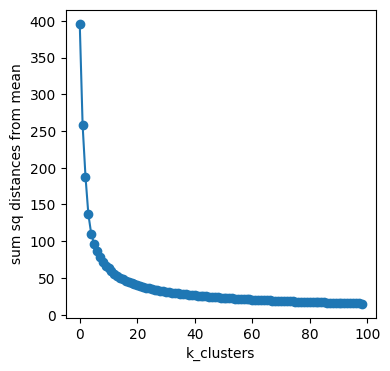

In [ ]:
r_seed = 24
cluster_errors = []

k_max = 100
for i in range(1, k_max):
    if i%10 == 0: print(i)
    n_clusters = i
    pipe_pca_kmean = Pipeline([("cluster", KMeans(n_init='auto',n_clusters=n_clusters, random_state=r_seed, verbose=0))]
    )

    pipe_pca_kmean.fit(X_reduced)
    pipe_pca_kmean.predict(X_reduced)
    cluster_errors.append(pipe_pca_kmean.named_steps["cluster"].inertia_)

# Plot
plt.clf()
plt.figure(figsize=(4,4))
plt.plot(cluster_errors, "o-")
plt.xlabel("k_clusters")
plt.ylabel("sum sq distances from mean")
plt.show()

In [ ]:
# Find the optimal value of k with KneeLocator
kl = KneeLocator(range(1, k_max), cluster_errors, curve="convex", direction="decreasing")

# Predict the clusters on our dataset

In [ ]:
k_optimal = kl.elbow
print('k_optimal = ', k_optimal)

k_optimal =  13


In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init='auto')
y_pred = kmeans.fit_predict(X_reduced)

# Plot the clustering: UMAP


In [ ]:
!pip install umap-learn -q

import time
import seaborn as sns
import plotly.express as px
from umap import UMAP

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 6.3 MB/s eta 0:00:00


In [ ]:
# UMAP Definition:
start_time = time.time()
umap_embeddings = UMAP(min_dist=0.1, n_components=n_components)
X_umap = umap_embeddings.fit_transform(X_reduced)
print(f"\ncomputation time (s): {time.time()-start_time}")

######### PLOT ##########

if n_components == 3:
    x, y, z = list(zip(*X_umap))
    fig = px.scatter_3d(df, x, y, z, color=y_pred.astype(str),
                        color_discrete_sequence=px.colors.qualitative.Dark24,
                        hover_data=['category', 'title'])
    fig.update_traces(marker_size=3)

elif n_components == 2:
    fig = px.scatter(df, x=X_umap[:,0], y=X_umap[:,1], color=y_pred.astype(str),
                     hover_data=['category','title',],
                     height= 600, width=600,
                     title = "uMAP")
    fig.update_traces(marker_size=5)

fig.show()


computation time (s): 79.7233681678772
